In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from UnifiedMomentumModel.Momentum import UnifiedMomentum, ThrustBasedUnified
from matplotlib.colors import ListedColormap
from scipy.stats import describe

# Analytical Models

## Define Analytical Models

In [ ]:
def classical(ctp):  # return Cp for classical momentum theory
    a = ctp / (4 + ctp)
    return 4 * a * (1 - a)**2

In [ ]:
def johlas(ctp, sa, pa):  # return Cp for classical momentum theory adjusted by coefficents in Johlas 2020
    cp = classical(ctp)
    x_disp = (1 + (3 * (sa**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp  # coefficents from turbine movement

In [ ]:
def umm(ctp, sf, sa, pa):
    model = UnifiedMomentum()
    sf_rad = np.deg2rad(sf)
    sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
    sa_vals = (sa * sin_vals) + 1
    sa_vals_cubed = sa_vals**3
    pa_vals = np.deg2rad(pa) * sin_vals
    umm_vals = [sa_vals_cubed * model(Ctprime = c, yaw = 0.0, tilt = pa_vals).Cp for c in np.atleast_1d(ctp)] # list of list
    Cp_stats_list = [describe(vals) for vals in umm_vals]
    umm_means = np.array([stats.mean for stats in Cp_stats_list])
    umm_std = np.array([np.std(vals) for vals in umm_vals])
    umm_skewness = np.array([stats.skewness for stats in Cp_stats_list])
    umm_kurtosis = np.array([stats.kurtosis for stats in Cp_stats_list])
    return umm_means, umm_std, umm_skewness, umm_kurtosis

## Plot Analytical Models

In [ ]:
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:red']

### For this initial exploration, we will use $f = 1.0$ and $A_S = 0.5$ & $A_P = 5^\circ$. 

In [ ]:
ctp_list = np.linspace(0.01, 10, num = 100)

In [22]:
def fix_plot_legend(ax, xOffset = 1.85, title = ""):
    leg = ax.legend(title = title)
    bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    return

In [ ]:
def plot_mean_cp_models(ctp_list, f, sa, pa, palette = palette):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (10, 4), dpi = 300)
    fig.suptitle("Mean $C_P$ vs $C_T^'$", size = 16, y = 1.04)
    ax0.set_title(f"Surging ($f = {f}$, A = ${sa}$)", size = 14, y = 1.04)
    ax1.set_title(f"Pitching ($f = {f}$, A = ${pa}^\circ$)", size = 14, y = 1.04)
    ax0.set_xlabel('$C_T^\'$', size = 15)
    ax1.set_xlabel('$C_T^\'$', size = 15)
    ax0.set_ylabel('Mean $C_P$', size = 15)
    ax1.set_ylabel('Mean $C_P$', size = 15)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_ylim(0, 1)
    linewidth = 3.5
    classical_cp = classical(ctp_list)
    # plot surging
    johlas_cp_surge = johlas(ctp_list, sa, 0)
    umm_cp_surge_means, _, _, _ = umm(ctp_list, f, sa, 0)
    sns.lineplot(ax = ax0, x = ctp_list, y = classical_cp, color=palette[0], label = "Classical", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = johlas_cp_surge, color=palette[1], label = "Johlas", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = umm_cp_surge_means, color=palette[2], label = "Quasi-Steady UMM", linewidth = linewidth)
    # plot pitching
    johlas_cp_pitch = johlas(ctp_list, 0, pa)
    umm_cp_pitch_means, _, _, _ = umm(ctp_list, f, 0, pa)
    sns.lineplot(ax = ax1, x = ctp_list, y = classical_cp, color=palette[0], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = johlas_cp_pitch, color=palette[1], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = umm_cp_pitch_means, color=palette[2], linewidth = linewidth, legend=False)

    # adjust plot legend and spacing
    fix_plot_legend(ax0)
    fig.subplots_adjust(wspace=0.25)
    return fig, (ax0, ax1)


In [ ]:
f, sa, pa = 1, 0.5, 5
plot_mean_cp_models(ctp_list, f, sa, pa);

# Analyze LES Data

In [ ]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/expanded_moving_analysis_july_27_25.csv")
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df['rounded_dt'] = df.apply(lambda row: round(row["dt"], ndigits = 3), axis = 1)
df = df[df.nx >= 256]  # only keep simulations with high enough resolutions
df = df[df.filterFactor >= 1.5] # only keep simulations with high enough filter factors
df = df[df.useCorrection]
df = df[df.turbulence == False]

## Sensitivity to LES Parameters

## Failed Runs

Some runs fail due to instability. The runs are more likely to fail when the resolution is increased, as the floe fields are less smooth. In order to resolve these fields, the timestep may need to be decreased. When attempting to increase the resolution, I had quite a few runs fail at $C_T' = 4$. In hindsight, running at this high of a $C_T'$ might not even be physical, so I decided to move on and work with more reasonable $C_T'$ values. However, here I cataloged the runs that became unstable and crashed.

In [ ]:
df_nans = df[df.isna().any(axis=1)]
df_nans = df_nans.sort_values(by = ["nx", "dt", "filterFactor", "surge_freq", "surge_amplitude", "pitch_amplitude"])
df_nans[["CT_prime", "nx", "ny", "dt", "filterFactor", "filter", "surge_freq", "surge_amplitude", "pitch_amplitude", "mean_Cp"]]

We can see here that the runs with $n_x = 256$ that crashed all has a surge amplitude of $1$. This makes sense, as this basically brings the turbine to a standstill. Then, for $n_x = 512$, the runs will smaller surge frequencies and amplitude of 0.5 all crashed. To fix this, I tried all different filter factors (1.5 - 3.5), but this didn't help. Lowering the timestep artifically low for the higher frequency runs did help. This makes sense as this helps to resolve the more complex flow field. 

### Plot the Unstable Surging Runs (all but one!)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, dpi = 100, figsize = (10, 6), sharey = True, sharex = True)
fig.suptitle("Unstable Surging Runs")
ax0.set_title("$n_x = 256$")
ax0.set_xlabel('Frequency [St]', size = 12)
ax0.set_ylabel('$\\frac{\Delta}{h}$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.set_title("$n_x = 512$")
ax1.set_xlabel('Frequency [St]', size = 12)
ax1.set_ylabel(' ', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

sns.scatterplot(ax = ax0, data = df_nans[(df_nans.surge_amplitude != 0) & (df_nans.nx == 256)], x = "surge_freq", y = "filterFactor", hue = "surge_amplitude", style = "rounded_dt", palette = "tab10", s = 50)
sns.scatterplot(ax = ax1, data = df_nans[(df_nans.surge_amplitude != 0) & (df_nans.nx == 512)], x = "surge_freq", y = "filterFactor", hue = "surge_amplitude", style = "rounded_dt", palette = "tab10", s = 50)

## Completed Runs

We now consider all of the rest of the runs that sucessfully completed.

In [ ]:
df = df.dropna()
cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

We also create a few specialized datasets to help us plot specific subsets of the data, either by frequency and amplitude, or by LES parameters.

In [ ]:
low_res_df = df[(df.ny == 128) & (df.filterFactor == 1.5)]
high_res_df = df[(df.ny == 256)]

## Plot Mean $C_P$ LES Data for $f = 1$, $A_s = 0.5$, and $A_p = 5^\circ$ over $C_T'$ Values

In [ ]:
max_motion_df = low_res_df[low_res_df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

In [ ]:
fig, (ax0, ax1) = plot_mean_cp_models(ctp_list, f, sa, pa);
surging_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Surging"]
sns.scatterplot(ax  = ax0, data = surging_max_motion_df, x = "CT_prime", y = "mean_Cp", color = 'k', zorder = 5, s=50)
pitching_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Pitching"]
sns.scatterplot(ax = ax1, data = pitching_max_motion_df, x = "CT_prime", y = "mean_Cp", color = 'k', zorder = 5, s=50, legend = False)
fix_plot_legend(ax0)

## Calculate Differences Between UMM and LES

In [ ]:
vals = df.apply((lambda row: umm(row.CT_prime, row.surge_freq, row.surge_amplitude, row.pitch_amplitude)), axis = 1)
means, stds, _, _ = zip(*vals)
df["umm_mean"] = np.ndarray.flatten(np.array(means))
df["percent_diff_umm"] = df.apply((lambda row: 100 * (row.umm_mean - row.mean_Cp) / row.mean_Cp), axis = 1)

In [ ]:
def get_yaxis_type(yaxis_key):
    if yaxis_key == "mean_Cp_ground" or yaxis_key == "percent_diff_umm_mean" or yaxis_key == "mean_Cp" or yaxis_key == "percent_diff_umm":
        yaxis_type = "Mean"
    elif yaxis_key == "std_Cp_ground" or yaxis_key == "percent_diff_umm_std":
        yaxis_type = "STD"
    elif yaxis_key == "skewness_Cp_ground" or yaxis_key == "percent_diff_umm_skewness":
        yaxis_type = "Skewness"
    elif yaxis_key == "kurtosis_Cp_ground" or yaxis_key == "percent_diff_umm_kurtosis":
        yaxis_type = "Kurtosis"
    else:
        raise ValueError('Unknown yaxis_key!')
    return yaxis_type

In [ ]:
def get_yaxis_umm_key(yaxis_key):
    if yaxis_key == "mean_Cp_ground" or yaxis_key == "mean_Cp":
        get_yaxis_umm_key = "umm_mean"
    elif yaxis_key == "std_Cp_ground":
        get_yaxis_umm_key = "umm_std"
    elif yaxis_key == "skewness_Cp_ground":
        get_yaxis_umm_key = "umm_skewness"
    elif yaxis_key == "kurtosis_Cp_ground":
        get_yaxis_umm_key = "umm_kurtosis"
    else:
        raise ValueError('Unknown yaxis_key!')
    return get_yaxis_umm_key

In [ ]:
def plot_umm_les(df, mask = None, yaxis_key = "mean_Cp", style_key = None, subtitle = None, sharey = True):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = sharey, figsize = (8, 3), dpi = 300)
    yaxis_type = get_yaxis_type(yaxis_key)
    umm_yaxis_key = get_yaxis_umm_key(yaxis_key)
    title_str = yaxis_type + f" $C_P$ vs Amplitude for Varying Frequencies"
    title_y = 1.08
    if subtitle is not None:
        title_str += "\n" + subtitle
        title_y += 0.08
    fig.suptitle(title_str, size = 16, y = title_y)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel(yaxis_type + ' $C_P$', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    ax0_data = df[(df["Movement"] == "Surging")]
    ax1_data = df[(df["Movement"] == "Pitching")]
    if mask is not None:
        ax0_data = ax0_data[mask]
        ax1_data = ax1_data[mask]
    if style_key is None:
        style_key = "surge_freq"
    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = yaxis_key, hue = "surge_freq", style = style_key, palette = palette, s=50)
    sns.lineplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = umm_yaxis_key, color = "k", label = "UMM")

    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = yaxis_key, hue = "surge_freq", style = style_key, palette = palette, s=50, legend = False)
    sns.lineplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = umm_yaxis_key, color = "k")

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    hspace = 0.5
    if not sharey:
        hspace = 0.9
    fig.subplots_adjust(hspace = hspace)


In [ ]:
def plot_umm_error(df, mask = None, yaxis_key = "percent_diff_umm", style_key = None, subtitle = None, sharey = True):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = sharey, figsize = (8, 3), dpi = 300)
    yaxis_type = get_yaxis_type(yaxis_key)
    title_str = "UMM " + yaxis_type + f" $C_P$ Error vs Amplitude for Varying Frequencies"
    title_y = 1.08
    if subtitle is not None:
        title_str += "\n" + subtitle
        title_y += 0.08
    fig.suptitle(title_str, size = 16, y = title_y)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel('UMM ' + yaxis_type + ' $C_P$ Error [%]', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    surge_mask = (df["Movement"] == "Surging")
    pitch_mask = (df["Movement"] == "Pitching")
    if mask is not None:
        surge_mask = surge_mask & mask
        pitch_mask = pitch_mask & mask
    ax0_data = df[surge_mask]
    ax1_data = df[pitch_mask]

    if style_key is None:
        style_key = "surge_freq"

    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = yaxis_key, hue = "surge_freq", style = style_key, palette = palette, s=50)
    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = yaxis_key, hue = "surge_freq", style = style_key, palette = palette, s=50, legend = False)

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    hspace = 0.5
    if not sharey:
        hspace = 0.9
    fig.subplots_adjust(hspace = hspace)


## Plot Mean $C_P$ from UMM for $C_T' = 1$ for a range of $f$ and $A$

In [ ]:
ctp = 1
mask = (df.filterFactor == 1.5) & (df.ny == 128) & (df.surge_freq < 1.5) & (df.CT_prime == ctp)
plot_umm_les(df, mask = mask, subtitle= "$C_T' = 1$")
plot_umm_error(df, mask = mask, subtitle= "$C_T' = 1$")

## Plot Mean $C_P$ from UMM for $C_T' = 4$ for a range of $f$ and $A$

I don't really trust the results of $C_T' = 4$. As can be seen below, the results change a lot based on the various LES parameters. I think $C_T' = 4$ is just too turbulent and may not even be reflective of any real phenomenon. Due to this, I decided to work with lower $C_T'$ values for the analysis after this section.

In [ ]:
ctp = 4
mask = (df.filterFactor == 1.5) & (df.ny == 128) & (df.surge_freq < 1.5) & (df.CT_prime == ctp)
plot_umm_les(df, mask = mask, subtitle= "$C_T' = 4$")
plot_umm_error(df, mask = mask, subtitle= "$C_T' = 4$")

## High $C_T'$ Run Sensitivity

For high $C_T'$ values, small changes in LES parameters can lead to large changes in values. I decided to test this out for the above $C_T' = 4$ values as I wasn't sure I could trust them. This turned out to be the correct mindset, as the values differed a LOT based on the LES parameters. This, paired with my issues getting high resolution $C_T' = 4$ simulations to run, documented above, led me to give up on analyzing the $C_T' = 4$ case for now and focus on more realistic parameters.

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Surging $A = 0.5$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.surge_amplitude == 0.5) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm_mean", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Pitching $A = 10^\circ$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.pitch_amplitude == 10) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm_mean", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)

## Analysis of $C_T' = 1.33, 1.66, 2.0$ Cases along various $f$ and $A$

At this point, I decided to run a new set of simulations at more "reasonable" values of $C_T'$. I also decided to up the resolution in the y and z directions after noticing streaks in the flow fields. I also upped the filter factor after noticing Gibb's phenomenon over the rotor. However, due to my increase in resoltuion, the absolutde width of the filter stayed about the same.

I decided to work with even numbers of $f$ and $A$ and to push the pitch amplitude up a lot since nothing interesting was happening below $10^\circ$ anyways.

I also updated the way that I was calculating $a_n$ and $C_P$. I now calcualte it in two frames of reference.

In the **ground frame**, I add the movement of the turbine to the disk velocity. In this frame of reference, I still say that $u_\infty = 1$, but I say that $u_\text{rel} = u_t + u_d$. 

I also then added in calculations in the **turbine frame of reference**. In this frame of reference, $u_\infty = 1 - u_t$ and $u_\text{rel} = u_d$. 

Thus at any given moment, where $\phi$ is tilt:

$a_n =  1 - \frac{u_\text{rel}}{u_\infty * \cos(\phi)}$

$C_P = \frac{P}{\frac{1}{2} \rho \pi (\frac{D}{2})^2 u_\infty^3 \cos^3(\phi)}$

We will compare the results per frame of reference below. Since I changed the names of the columns in the new dataset, I need to redefine the plotting code.

In [ ]:
df_final = pd.read_csv("/Users/sky/src/HowlandLab/data/updated_moving_analysis_08_06.csv")
# add in rows for easier analysis
df_final['Movement'] = df_final.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df_final['rounded_dt'] = df_final.apply(lambda row: round(row["dt"], ndigits = 3), axis = 1)
vals = df_final.apply((lambda row: umm(row.CT_prime, row.surge_freq, row.surge_amplitude, row.pitch_amplitude)), axis = 1)
means, stds, skewness, kurtosis = zip(*vals)
df_final["umm_mean"] = np.ndarray.flatten(np.array(means))
df_final["umm_std"] = np.ndarray.flatten(np.array(stds))
df_final["umm_skewness"] = np.ndarray.flatten(np.array(skewness))
df_final["umm_kurtosis"] = np.ndarray.flatten(np.array(kurtosis))
# clean dataset
df_final = df_final.dropna()
df_final = df_final.drop_duplicates(subset = cols_to_keep, keep = 'last')

In [ ]:
df_final["percent_diff_umm_mean"] = df_final.apply((lambda row: 100 * (row.umm_mean - row.mean_Cp_ground) / row.mean_Cp_ground), axis = 1)
df_final["percent_diff_umm_std"] = df_final.apply((lambda row: 100 * (row.umm_std - row.std_Cp_ground) / row.std_Cp_ground), axis = 1)
df_final["percent_diff_umm_skewness"] = df_final.apply((lambda row: 100 * (row.umm_skewness - row.skewness_Cp_ground) / row.skewness_Cp_ground), axis = 1)
df_final["percent_diff_umm_kurtosis"] = df_final.apply((lambda row: 100 * (row.umm_kurtosis - row.kurtosis_Cp_ground) / row.kurtosis_Cp_ground), axis = 1)

In [ ]:
df_final

## Mean Values

In [ ]:
ctp = 1.33
mask = (df_final.CT_prime == ctp)
plot_umm_les(df_final, mask = mask, yaxis_key = "mean_Cp_ground", subtitle= "$C_T' = 1.33$")
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_mean", subtitle= "$C_T' = 1.33$")

In [ ]:
ctp = 2
mask = df_final.CT_prime == ctp
plot_umm_les(df_final, mask = mask, yaxis_key = "mean_Cp_ground", subtitle= "$C_T' = 2$")
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_mean", subtitle= "$C_T' = 2$")

## STD Values

In [ ]:
ctp = 1.33
mask = (df_final.CT_prime == ctp)
plot_umm_les(df_final, mask = mask, yaxis_key = "std_Cp_ground", subtitle= "$C_T' = 1.33$", sharey = False)
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_std", subtitle= "$C_T' = 1.33$", sharey = False)

In [ ]:
ctp = 2
mask = (df_final.CT_prime == ctp)
plot_umm_les(df_final, mask = mask, yaxis_key = "std_Cp_ground", subtitle= "$C_T' = 2$", sharey = False)
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_std", subtitle= "$C_T' = 2$", sharey = False)

## Skewness Values

In [ ]:
ctp = 1.33
mask = (df_final.CT_prime == ctp) & ((df_final.surge_amplitude != 0))
plot_umm_les(df_final, mask = mask, yaxis_key = "skewness_Cp_ground", subtitle= "$C_T' = 1.33$", sharey = False)
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_skewness", subtitle= "$C_T' = 1.33$", sharey = False)

In [ ]:
ctp = 2
mask = (df_final.CT_prime == ctp) & ((df_final.surge_amplitude != 0))
plot_umm_les(df_final, mask = mask, yaxis_key = "skewness_Cp_ground", subtitle= "$C_T' = 2$", sharey = False)
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_skewness", subtitle= "$C_T' = 2$", sharey = False)

## Kurtosis

In [ ]:
ctp = 1.33
mask = (df_final.CT_prime == ctp) & ((df_final.surge_amplitude != 0))
plot_umm_les(df_final, mask = mask, yaxis_key = "kurtosis_Cp_ground", subtitle= "$C_T' = 1.33$", sharey = False)
plot_umm_error(df_final, mask = mask, yaxis_key= "percent_diff_umm_kurtosis", subtitle= "$C_T' = 1.33$", sharey = False)

In [ ]:
surge_df_final = df_final[df_final.surge_amplitude != 0]

In [ ]:
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel("St")
ax.set_ylabel("Amplitude [-]")
ax.set_zlabel("UMM Mean $C_P$ Error [%]")
sns.set_style("whitegrid")
cmap = ListedColormap(sns.color_palette("rainbow", 256).as_hex())
sc = ax.scatter3D(surge_df_final.surge_freq, surge_df_final.surge_amplitude, surge_df_final.percent_diff_umm_mean, c = surge_df_final.CT_prime, cmap = cmap)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title = "$C_T'$")
ax.view_init(-150, 15)

# Dataset with all timepoints

## LES Data

When analyzing the LES data, we must recall that $U_d$ as output by PadeOps, already includes the turbine motion (i.e. it is in the perspective of a stationary turbine). We also want to calculate $a_n$, $C_T$, and $C_P$ from the perspective of a stationary turbine.

In [81]:
rho, uinf, D = 1, 1, 1

In [82]:
df_les = pd.read_csv("/Users/sky/src/HowlandLab/data/sim_16_all_runs_data_points.csv")
df_les = df_les.dropna()
df_les = df_les[((df_les["Thrust Coefficient"] != 1.66) & (df_les["Frequency"] < 1))]
df_les = df_les[(((df_les["Movement"] == "Pitch") & (df_les["Amplitude"] < 20)) | ((df_les["Movement"] == "Surge") & (df_les["Amplitude"] < 1)))]
df_les["Model"] = "LES - $C_T'$ Input"

In [83]:
df_les = df_les.rename(columns={'UDisk': 'UDisk_Turb', 'Thrust Coefficient': 'Local Thrust Coefficient'}) # disk velocity in the turbine frame of reference
df_les["UDisk_Ground"] = df_les["UDisk_Turb"] + df_les["UTurb"] # disk velocity in the ground frame of reference

In [176]:
df_les["UInf_Turb"] = (uinf - df_les["UTurb"]) * np.cos(df_les["Tilt"])
df_les["UInf_Ground"] = uinf

In [177]:
def calc_an(df, ud_key, uinf_key):
    return 1 - (df[ud_key] / df[uinf_key])

def calc_ct(df, ud_key, uinf_key):
    return (df["Local Thrust Coefficient"] * (df[ud_key])**2) / (df[uinf_key])**2

def calc_cp(df, uinf_key = "UInf_Turb"):  # power in PadeOps and UMM is calculated in the turbine frame of reference!
    return df.Power / (0.5 * rho * math.pi * (D/2)**2 * (df[uinf_key])**3)

In [178]:
df_les["an_Turb"] = calc_an(df_les, ud_key = "UDisk_Turb", uinf_key = "UInf_Turb")
df_les["an_Ground"] = calc_an(df_les, ud_key = "UDisk_Ground", uinf_key = "UInf_Ground")
df_les["an_Simple"] = calc_an(df_les, ud_key = "UDisk_Turb", uinf_key = "UInf_Ground")

In [179]:
LES_an_Turb = df_les["an_Turb"]
LES_an_Ground = df_les["an_Ground"]
LES_an_Simple = df_les["an_Simple"]
df_les["an_Turb_error"] = 0
df_les["an_Ground_error"] = 0
df_les["an_Simple_error"] = 0

## UMM Data

Once we have the values for the LES data, we can calcualte the UMM results using the same tilt and turbine velocity data, at the same times.

In [206]:
def copy_df(df, model_name):
    new_df = df.copy()
    new_df["Model"] = model_name
    # these must all be recalculated for a new model
    new_df["Power"] = np.nan
    new_df["UDisk_Turb"] = np.nan
    new_df["UDisk_Ground"] = np.nan
    new_df["an_Turb"] = np.nan
    new_df["an_Ground"] = np.nan
    new_df["an_Simple"] = np.nan
    new_df["an_Turb_error"] = np.nan
    return new_df

In [207]:
df_umm_ctp = copy_df(df_les, "UMM - $C_T'$ Input")

In [12]:
model_ctp = UnifiedMomentum()
umm_results_ctp = df_umm_ctp.apply(lambda row:(model_ctp(Ctprime = row["Local Thrust Coefficient"], yaw = 0.0, tilt = row["Tilt"])), axis = 1)

/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:89: RuntimeWarning: invalid value encountered in divide
  cos_a = np.divide(np.sin(yaw), sin_eff, where = tilt != 0, out = cos_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:90: RuntimeWarning: divide by zero encountered in divide
  sin_a = np.divide(-(np.sin(tilt) * np.cos(yaw)), sin_eff, where = tilt != 0, out = sin_a)
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:94: RuntimeWarning: invalid value encountered in multiply
  w = sin_a * eff_v


In [208]:
output_an_vals = np.array([umm_sol.an for umm_sol in umm_results_ctp])
df_umm_ctp["UDisk_Turb"] = (1 - output_an_vals) * df_umm_ctp["UInf_Turb"]
df_umm_ctp["UDisk_Ground"] = df_umm_ctp["UDisk_Turb"] + df_umm_ctp["UTurb"]

In [209]:
df_umm_ctp["an_Turb"] = calc_an(df_umm_ctp, ud_key = "UDisk_Turb", uinf_key = "UInf_Turb")
df_umm_ctp["an_Ground"] = output_an_vals
df_umm_ctp["an_Simple"] = calc_an(df_umm_ctp, ud_key = "UDisk_Turb", uinf_key = "UInf_Ground")

In [210]:
df_umm_ctp["an_Turb_error"] = ((df_umm_ctp["an_Turb"] - LES_an_Turb) / LES_an_Turb) * 100
df_umm_ctp["an_Ground_error"] = ((df_umm_ctp["an_Ground"] - LES_an_Ground) / LES_an_Ground) * 100
df_umm_ctp["an_Simple_error"] = ((df_umm_ctp["an_Simple"] - LES_an_Simple) / LES_an_Simple) * 100

In the UMM, we are assuming a fluxtuating inflow, rather than a moving turbine. This is why we let $U_\infty' = (U_\infty + U_\text{turb})$. The UMM already accounts for the effects of tilt in its calcualtion of $a_n$ and $C_P$.

In [211]:
df_combo = pd.concat([df_les, df_umm_ctp], ignore_index=True)
df_combo["Model Frequency"] = df_combo["Model"].astype(str) + ": " + df_combo["Frequency"].astype(str)

In [212]:
df_combo_surge = df_combo[df_combo["Movement"] == "Surge"]
df_combo_pitch = df_combo[df_combo["Movement"] == "Pitch"]

## $a_n$ Analysis

There are a lot of different ways to calculate $a_n$, so the first thing to do is to decide on what way we want to do that - and also to make sure that our definitions match across LES and the quasi-steady UMM. To check on this, I plotted all of the different definitions for a small subset of the data.

In [213]:
def small_mask(df):
    return df[(df.Frequency == 0.2) & (df.Amplitude == 0.4) & (df["Local Thrust Coefficient"] == 1.33) & (df.Time > 285)]

df_les_small = small_mask(df_les)
df_umm_ctp_small = small_mask(df_umm_ctp)

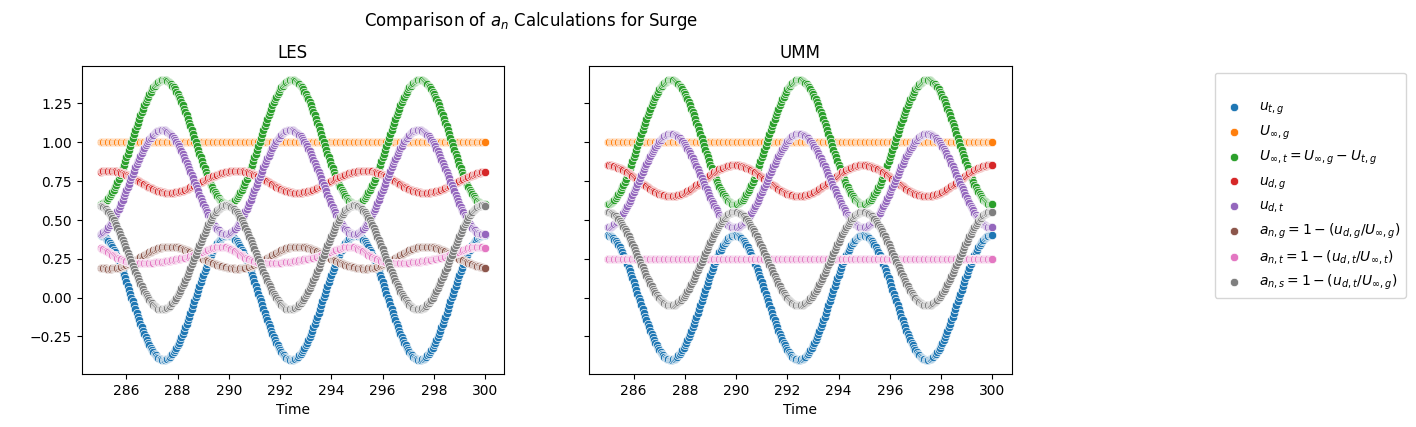

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12, 4))
fig.suptitle("Comparison of $a_n$ Calculations for Surge", y = 1.02)
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UTurb", label = "$u_{t, g}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UInf_Ground", label = "$U_{\infty, g}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UInf_Turb", label = "$U_{\infty, t} = U_{\infty, g} - U_{t, g}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UDisk_Ground", label = "$u_{d, g}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UDisk_Turb", label = "$u_{d, t}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Ground", label = "$a_{n, g} = 1 - (u_{d, g} / U_{\infty, g})$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Turb", label = "$a_{n, t} = 1 - (u_{d, t} / U_{\infty, t})$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Simple", label = "$a_{n, s} = 1 - (u_{d, t} / U_{\infty, g})$")
ax1.set_title("LES")
ax1.set_ylabel(" ")

sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UTurb", label = "$u_{t, g}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UInf_Ground", label = "$U_{\infty, g}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UInf_Turb", label = "$U_{\infty, t} = U_{\infty, g} - U_{t, g}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UDisk_Ground", label = "$u_{d, g}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UDisk_Turb", label = "$u_{d, t}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Ground", label = "$a_{n, g} = 1 - (u_{d, g} / U_{\infty, g})$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Turb", label = "$a_{n, t} = 1 - (u_{d, t} / U_{\infty, t})$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Simple", label = "$a_{n, s} = 1 - (u_{d, t} / U_{\infty, g})$", legend = False)
ax2.set_title("UMM")

fix_plot_legend(ax1, xOffset = 2.15, title = " ")

In [245]:
def small_mask(df):
    return df[(df.Frequency == 0.2) & (df.Amplitude == 8) & (df["Local Thrust Coefficient"] == 1.33) & (df.Time > 280)]

df_les_small = small_mask(df_les)
df_umm_ctp_small = small_mask(df_umm_ctp)

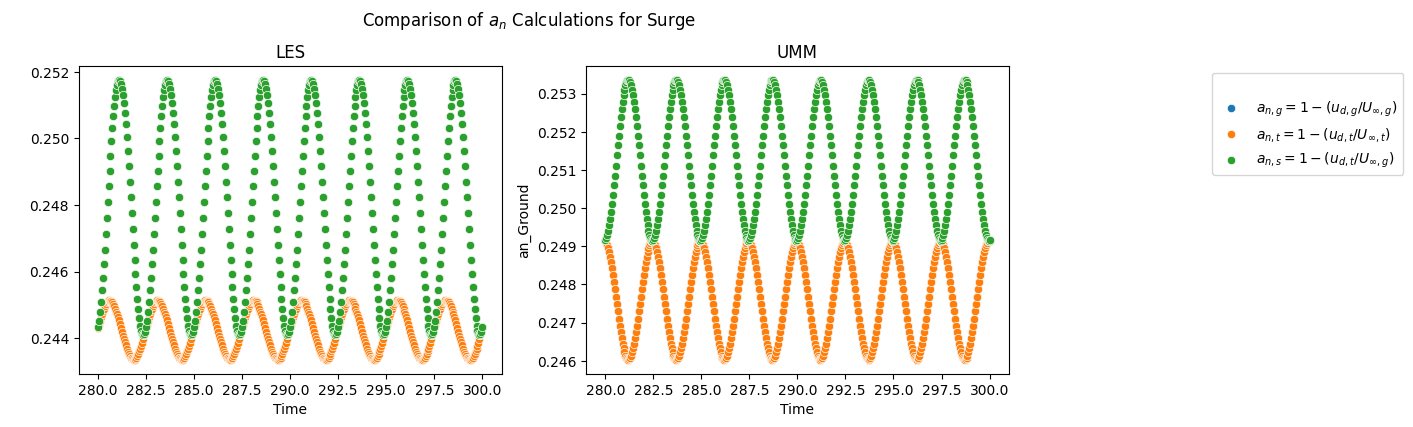

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (12, 4))
fig.suptitle("Comparison of $a_n$ Calculations for Surge", y = 1.02)
# sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "Tilt", label = "$\phi$")
# sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UInf_Ground", label = "$U_{\infty, g}$")
# sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UInf_Turb", label = "$U_{\infty, t} = U_{\infty, g} - U_{t, g}$")
# sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UDisk_Ground", label = "$u_{d, g}$")
# sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "UDisk_Turb", label = "$u_{d, t}$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Ground", label = "$a_{n, g} = 1 - (u_{d, g} / U_{\infty, g})$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Turb", label = "$a_{n, t} = 1 - (u_{d, t} / U_{\infty, t})$")
sns.scatterplot(ax = ax1, data=df_les_small, x = "Time", y = "an_Simple", label = "$a_{n, s} = 1 - (u_{d, t} / U_{\infty, g})$")
ax1.set_title("LES")
ax1.set_ylabel(" ")

# sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "Tilt", label = "$\phi$",  legend = False)
# sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UInf_Ground", label = "$U_{\infty, g}$", legend = False)
# sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UInf_Turb", label = "$U_{\infty, t} = U_{\infty, g} - U_{t, g}$", legend = False)
# sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UDisk_Ground", label = "$u_{d, g}$", legend = False)
# sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "UDisk_Turb", label = "$u_{d, t}$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Ground", label = "$a_{n, g} = 1 - (u_{d, g} / U_{\infty, g})$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Turb", label = "$a_{n, t} = 1 - (u_{d, t} / U_{\infty, t})$", legend = False)
sns.scatterplot(ax = ax2, data=df_umm_ctp_small, x = "Time", y = "an_Simple", label = "$a_{n, s} = 1 - (u_{d, t} / U_{\infty, g})$", legend = False)
ax2.set_title("UMM")

fix_plot_legend(ax1, xOffset = 2.15, title = " ")

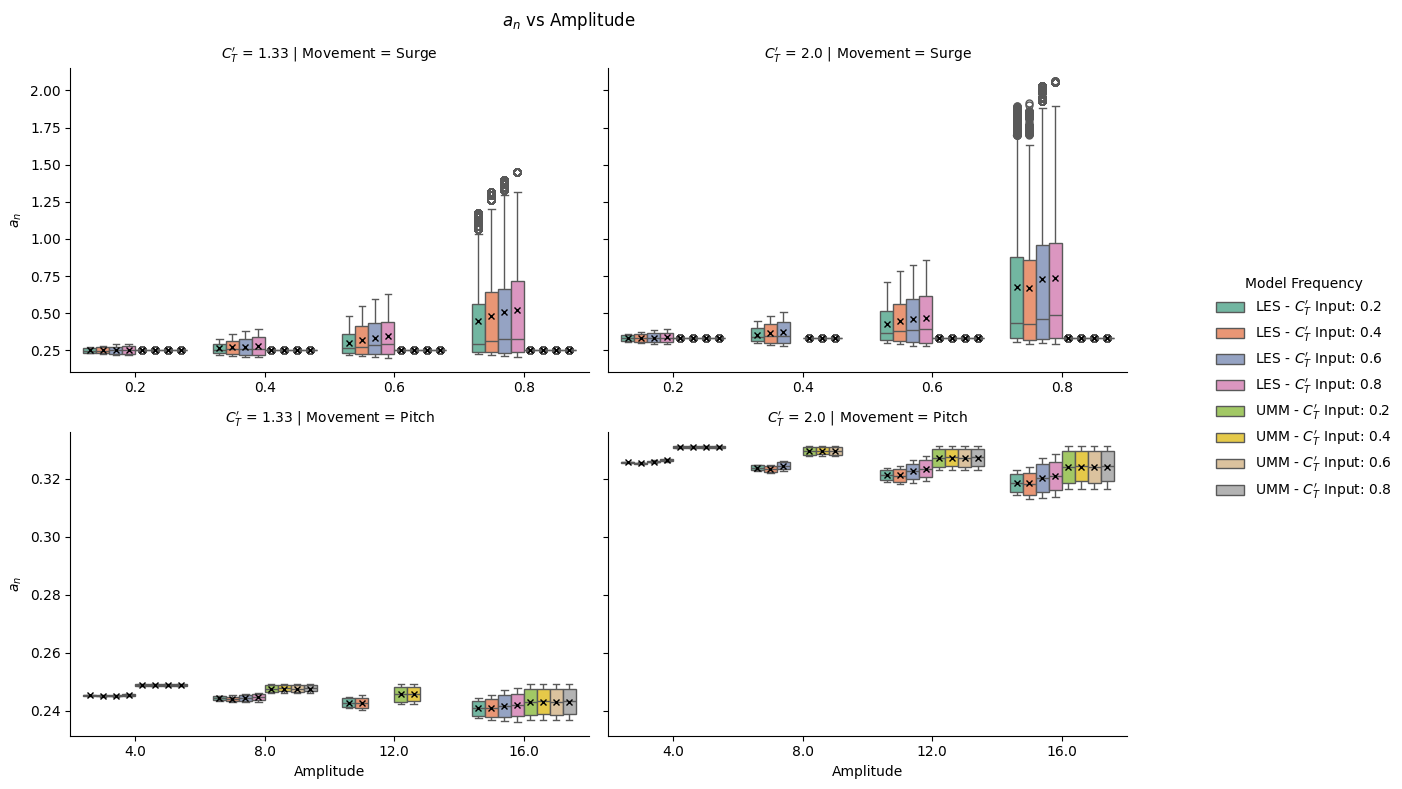

In [217]:
g = sns.catplot(
    data=df_combo,
    x="Amplitude",
    y="an_Turb",
    hue="Model Frequency",
    col="Local Thrust Coefficient",
    row="Movement",
    kind="box",
    height=4,
    aspect=1.2,
    palette="Set2",
    sharex=False,
    sharey="row",
    showmeans=True,
    meanprops={
        "marker": "x",        # Diamond shape
        "markerfacecolor": "black",
        "markeredgecolor": "black",
        "markersize": 4
    }
)

g.figure.suptitle('$a_n$ vs Amplitude')

g.set_titles(row_template="$C_T'$ = {col_name}", col_template="Movement = {row_name}")
g.set_axis_labels("Amplitude", "$a_n$")
g._legend.set_bbox_to_anchor((1.05, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
plt.tight_layout()

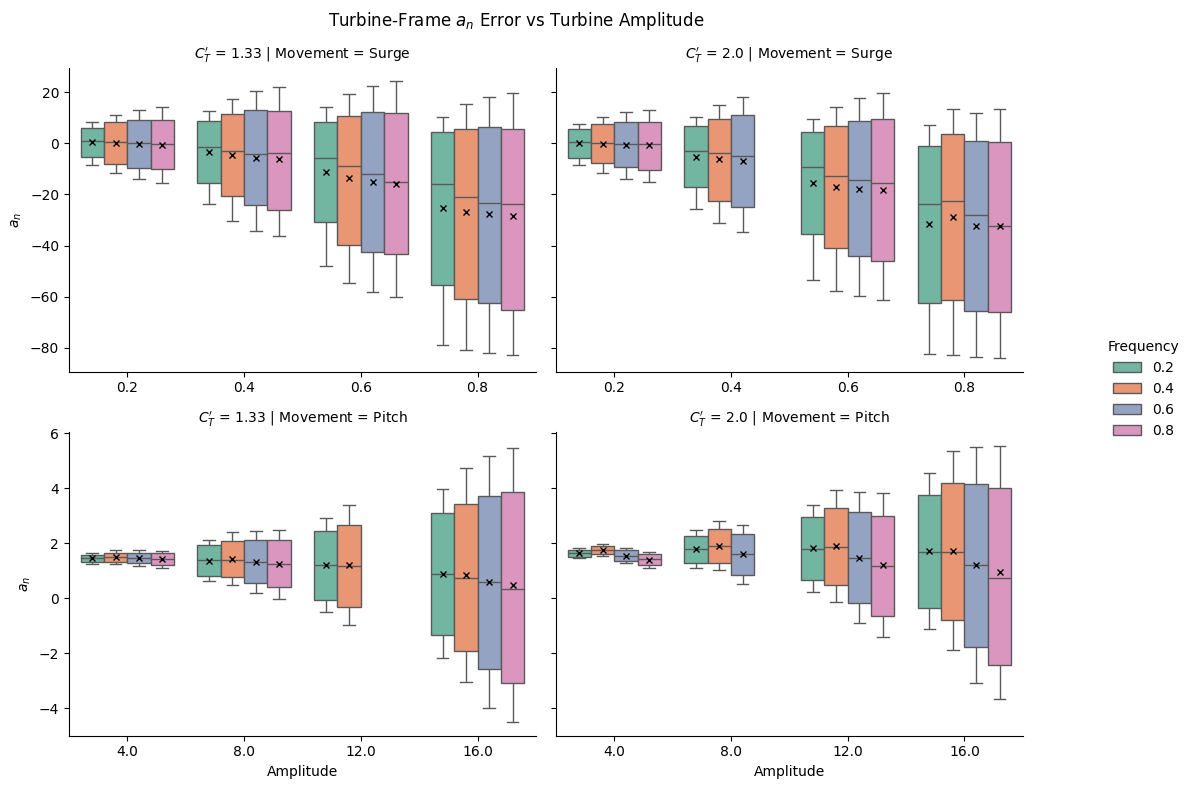

In [218]:
g = sns.catplot(
    data=df_combo[df_combo["Model"] == "UMM - $C_T'$ Input"],
    x="Amplitude",
    y="an_Turb_error",
    hue="Frequency",
    col="Local Thrust Coefficient",
    row="Movement",
    kind="box",
    height=4,
    aspect=1.2,
    palette="Set2",
    sharex=False,
    sharey="row",
    showmeans=True,
    meanprops={
        "marker": "x",        # Diamond shape
        "markerfacecolor": "black",
        "markeredgecolor": "black",
        "markersize": 4
    }
)

g.figure.suptitle('Turbine-Frame $a_n$ Error vs Turbine Amplitude')

g.set_titles(row_template="$C_T'$ = {col_name}", col_template="Movement = {row_name}")
g.set_axis_labels("Amplitude", "$a_n$")
g._legend.set_bbox_to_anchor((1.05, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
plt.tight_layout()

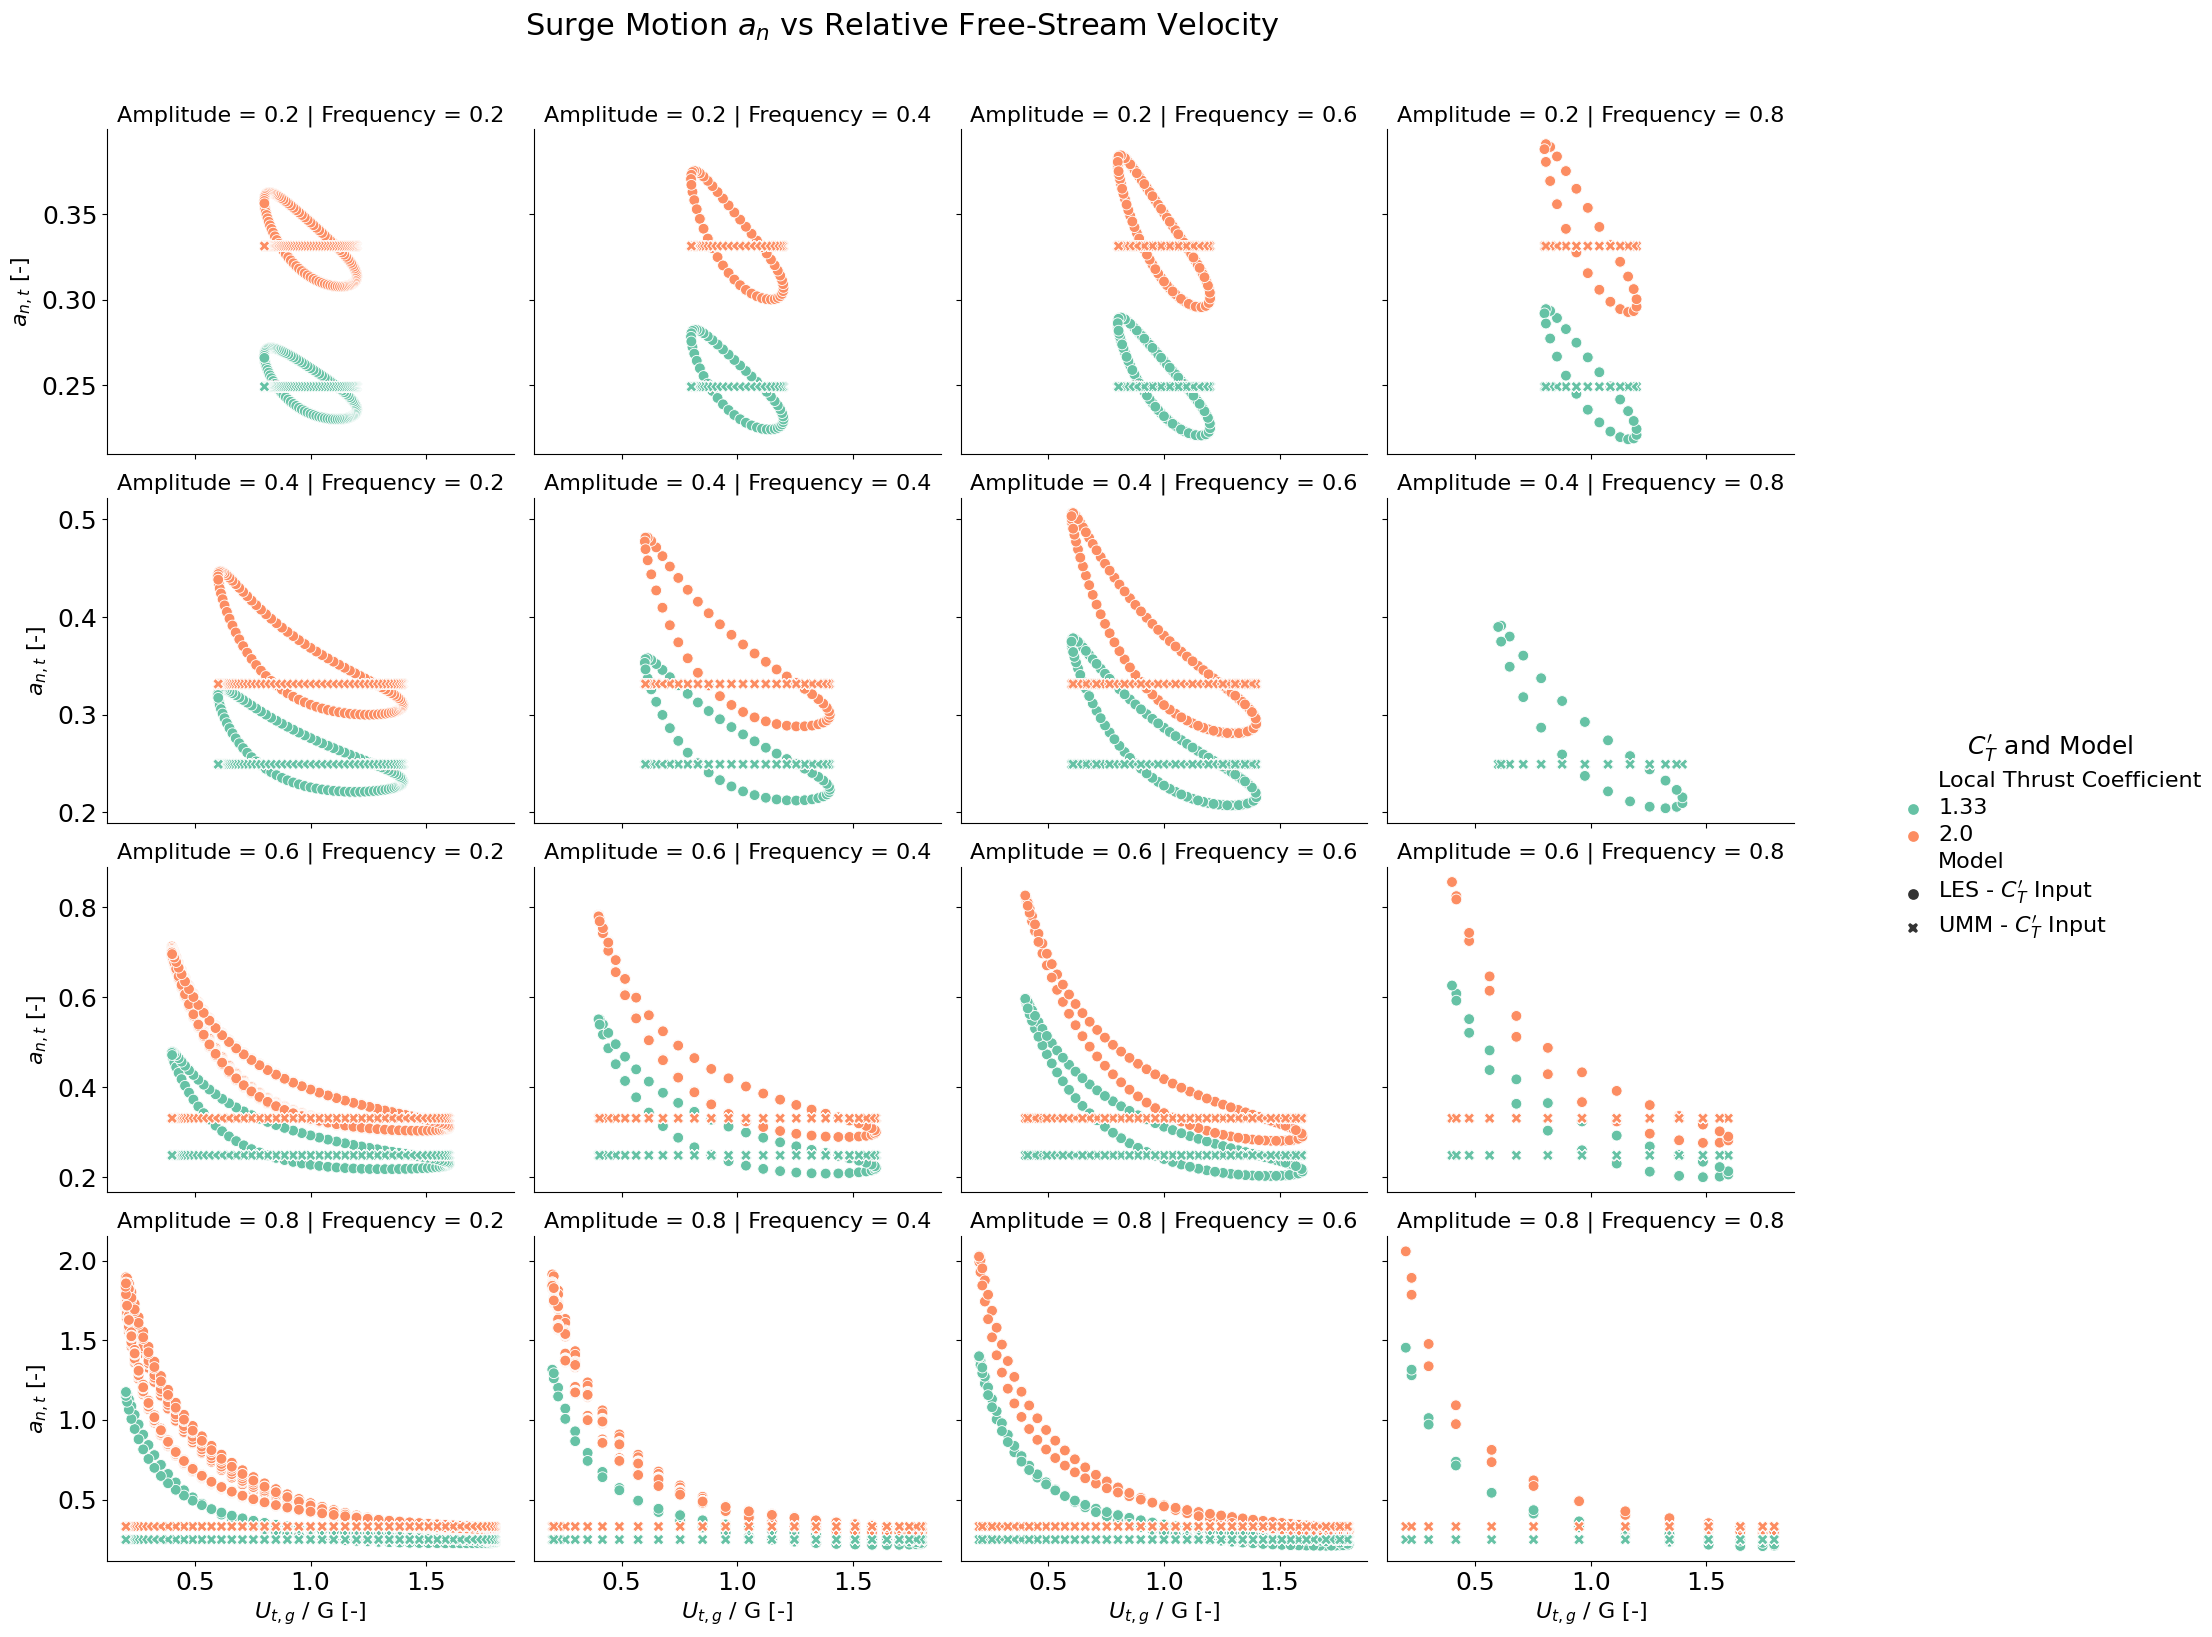

In [219]:
g = sns.relplot(
    data=df_combo_surge,
    x="UInf_Turb",
    y="an_Turb",
    style="Model",
    hue = "Local Thrust Coefficient",
    col="Frequency",
    row="Amplitude",
    kind="scatter",
    height=4,
    palette="Set2",
    facet_kws={"sharey": "row", "sharex": True},
    s = 60,
)

g.set_titles(row_template="Amplitude = {row_name}", col_template="Frequency = {col_name}", size = 16)
g.set_axis_labels("$U_{t, g}$ / G [-]", "$a_{n, t}$ [-]", fontsize = 16)
g._legend.set_title("$C_T'$ and Model", prop={'size': 18}); [t.set_fontsize(16) for t in g._legend.get_texts()]
g._legend.set_bbox_to_anchor((1.04, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
[ax.tick_params(labelsize=18) for ax in g.axes.flat]
g.figure.suptitle("Surge Motion $a_n$ vs Relative Free-Stream Velocity", fontsize=22, y = 1.02)
plt.tight_layout()

In [220]:
df_combo_pitch["Tilt_Degs"] = np.rad2deg(df_combo_pitch.Tilt)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_95558/1884787400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combo_pitch["Tilt_Degs"] = np.rad2deg(df_combo_pitch.Tilt)


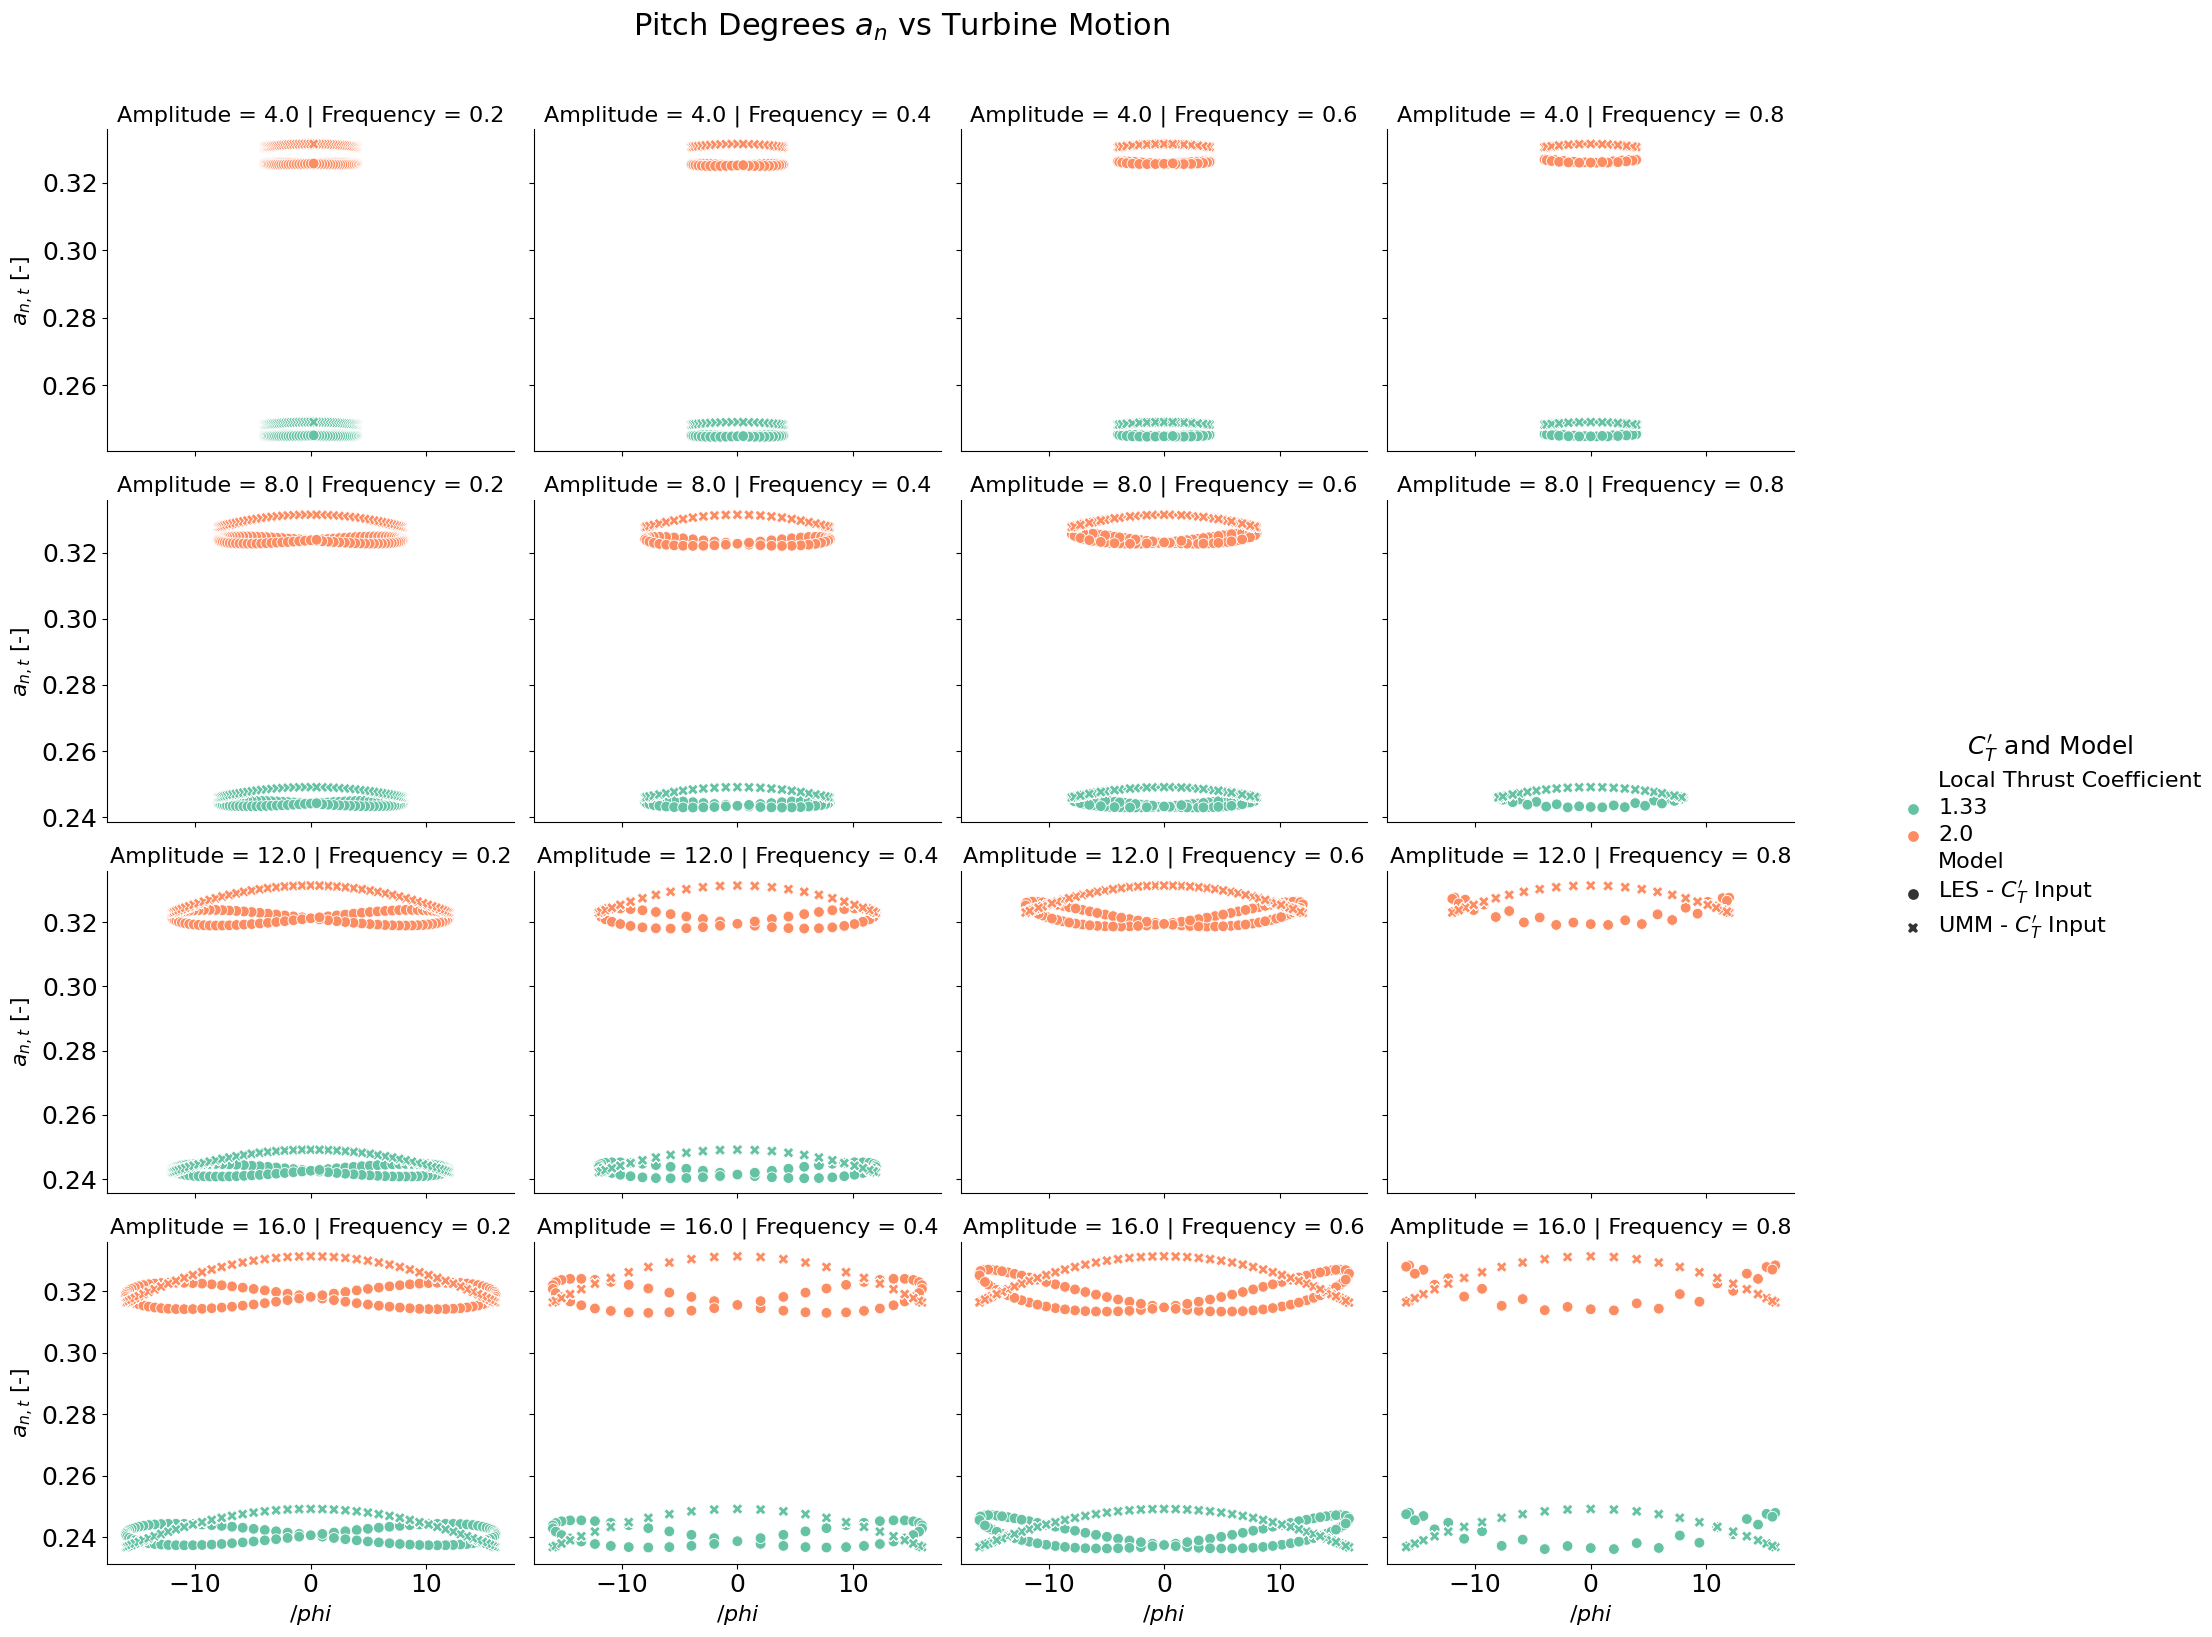

In [251]:
g = sns.relplot(
    data=df_combo_pitch,
    x="Tilt_Degs",
    y="an_Turb",
    style="Model",
    hue = "Local Thrust Coefficient",
    col="Frequency",
    row="Amplitude",
    kind="scatter",
    height=4,
    palette="Set2",
    facet_kws={"sharey": "row", "sharex": True},
    s = 60,
)

g.set_titles(row_template="Amplitude = {row_name}", col_template="Frequency = {col_name}", size = 16)
g.set_axis_labels("$/phi$", "$a_{n, t}$ [-]", fontsize = 16)
g._legend.set_title("$C_T '$ and Model", prop={'size': 18}); [t.set_fontsize(16) for t in g._legend.get_texts()]
g._legend.set_bbox_to_anchor((1.04, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
[ax.tick_params(labelsize=18) for ax in g.axes.flat]
g.figure.suptitle("Pitch Degrees $a_n$ vs Turbine Motion", fontsize=22, y = 1.02)
plt.tight_layout()

In [264]:
from scipy.fft import fft, fftfreq

fft_records = []
for (ct, move, freq, amp, model), group in df_combo.groupby(["Local Thrust Coefficient", "Movement", "Frequency", "Amplitude", "Model"]):
    an_vals = group["an_Turb"].values
    y = an_vals - np.mean(an_vals)
    N = len(y)
    T = group["Time"].iloc[1] - group["Time"].iloc[0]  # sampling interval

    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]       # positive freqs only
    power = 2.0 / N * np.abs(yf[0:N//2])

    temp_df = pd.DataFrame({
        "fft_freq": xf,
        "fft_power": power,
        "Local Thrust Coefficient": ct,
        "Movement": move,
        "Amplitude": amp,
        "Frequency": freq,
        "Model": model,
    })
    fft_records.append(temp_df)

fft_df = pd.concat(fft_records, ignore_index=True)

In [265]:
fft_surge_df = fft_df[fft_df["Movement"] == "Surge"]
fft_pitch_df = fft_df[fft_df["Movement"] == "Pitch"]

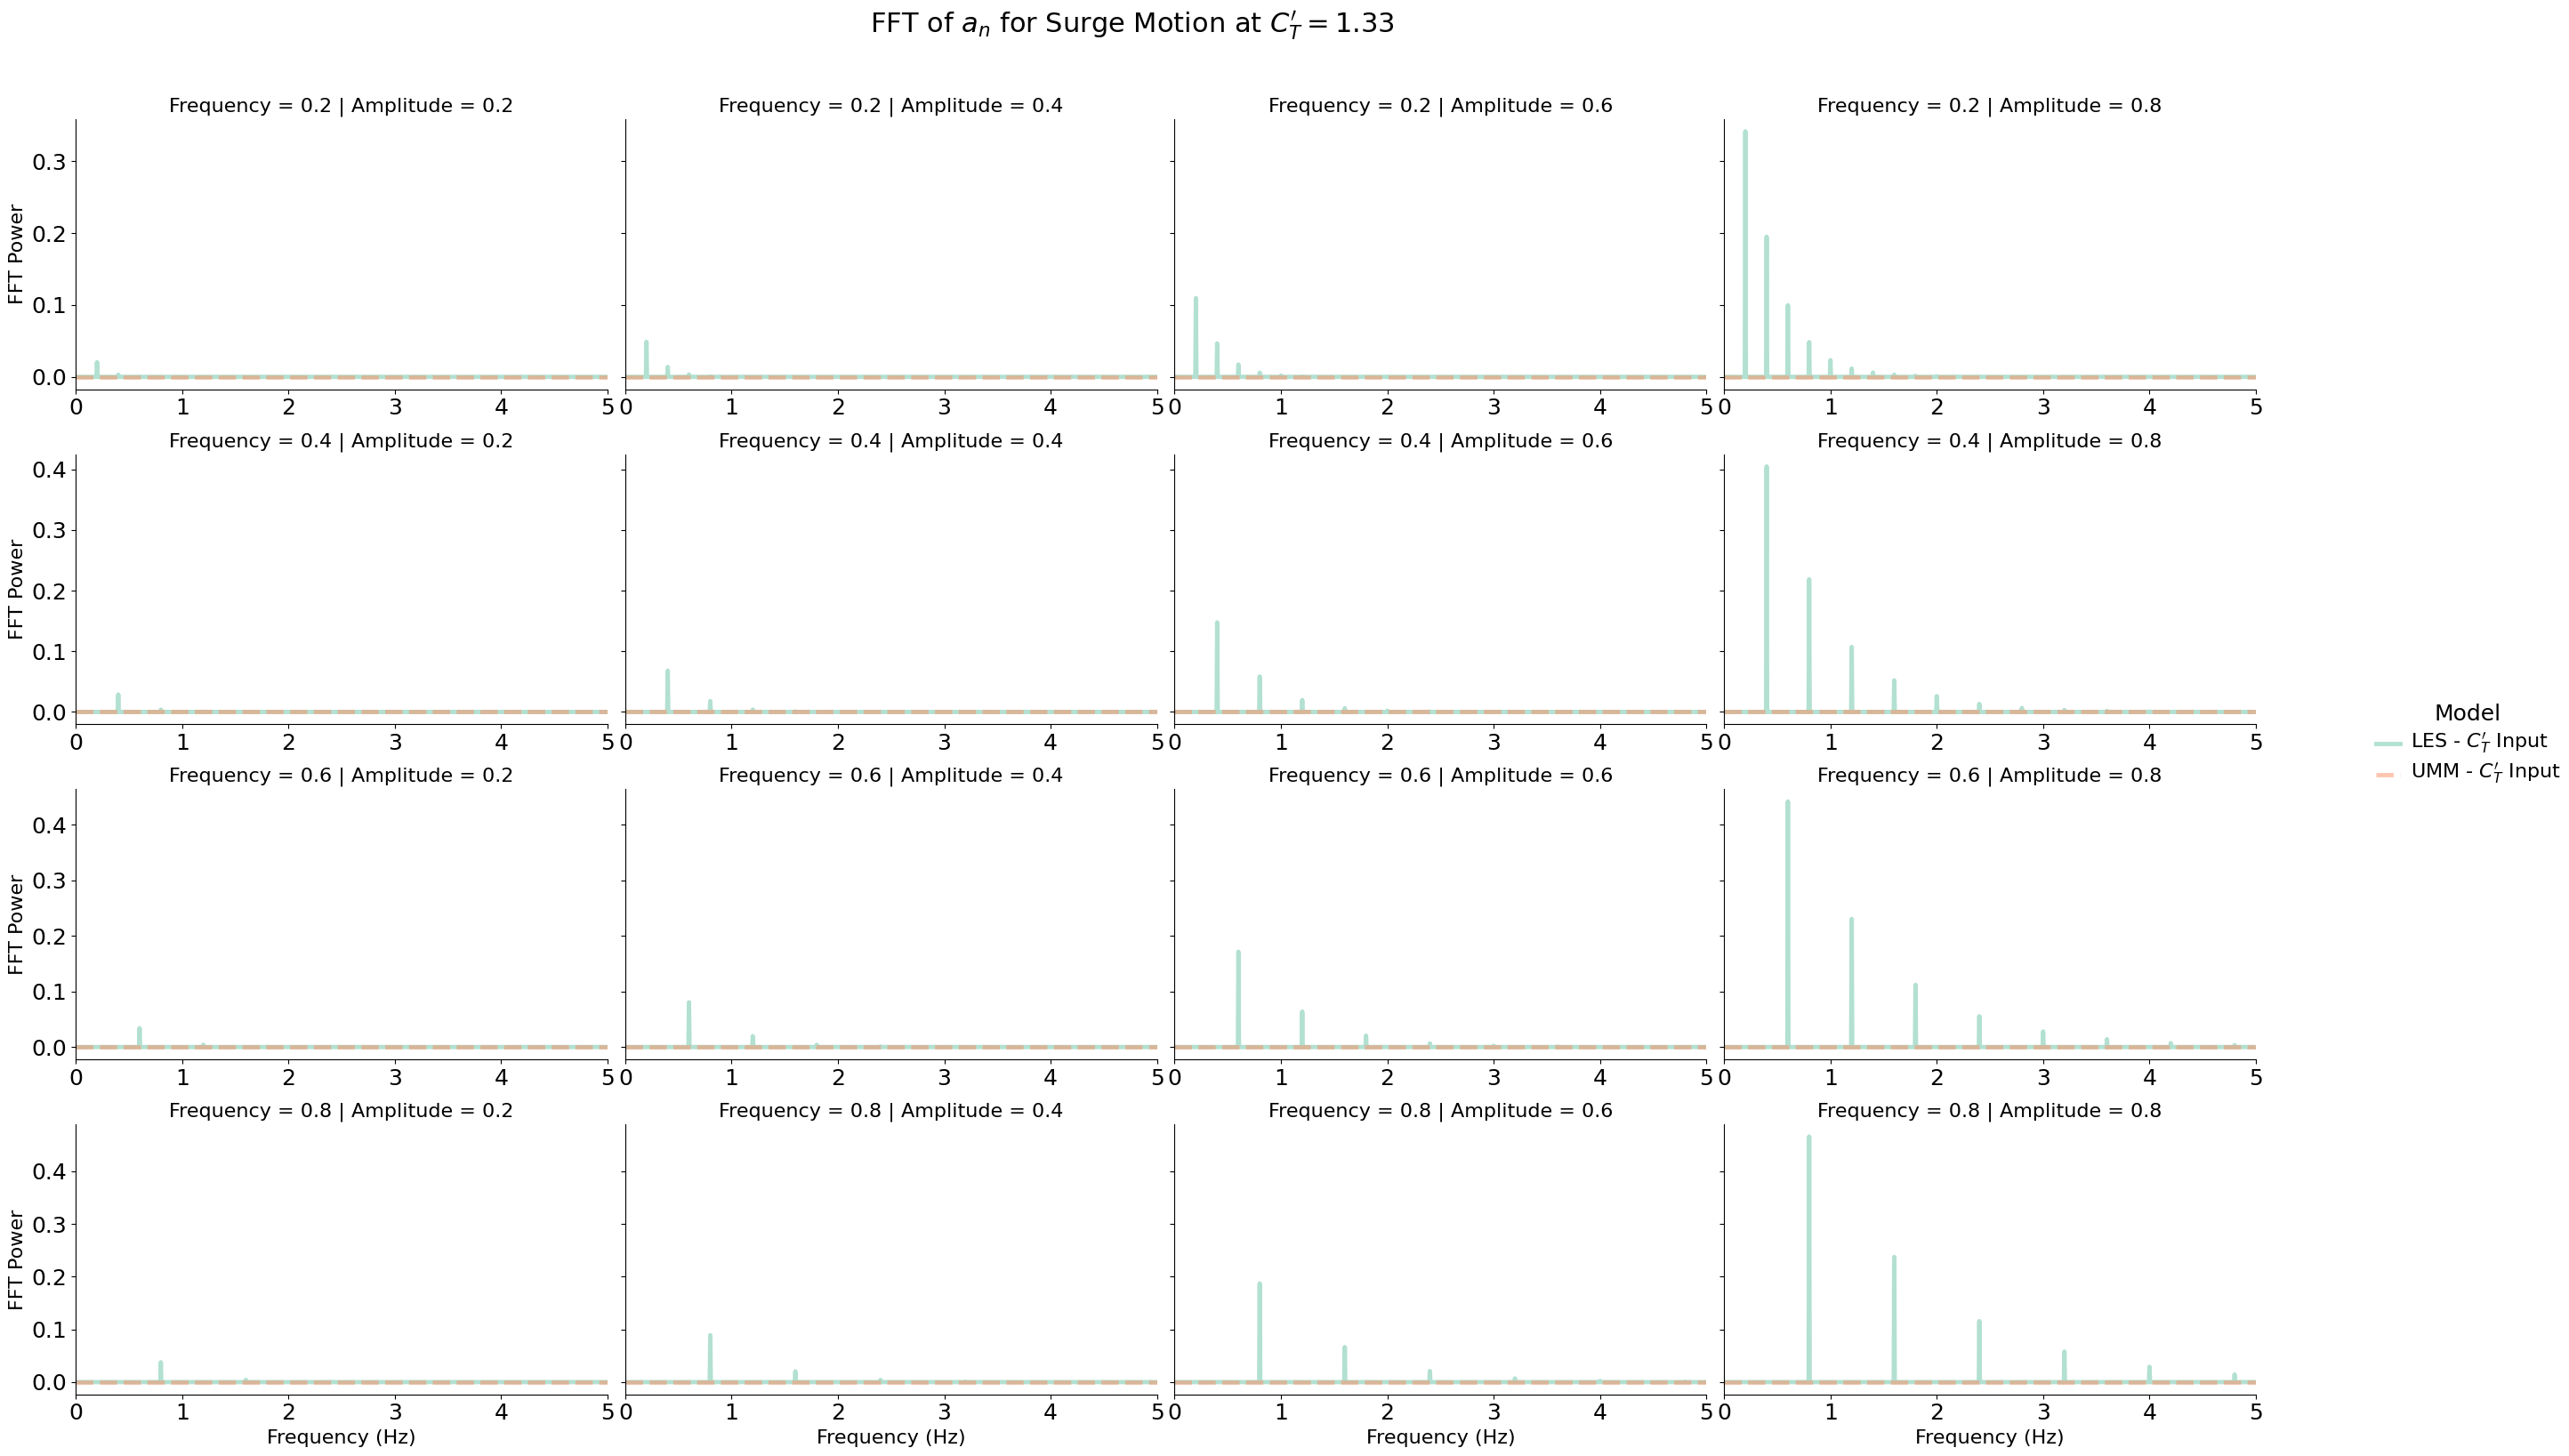

In [266]:
g = sns.relplot(
    data=fft_surge_df[fft_surge_df["Local Thrust Coefficient"] == 1.33],
    x="fft_freq",
    y="fft_power",
    hue="Model",
    style = "Model",
    col="Amplitude",
    row="Frequency",
    kind="line",
    height=4,
    aspect=1.5,
    palette="Set2",
    facet_kws={"sharey": "row", "sharex": False},
    errorbar= None,
    linewidth=3.5,
    alpha = 0.5
)

g.set_titles(row_template="Frequency = {row_name}", col_template="Amplitude = {col_name}", size = 16)
g.set_axis_labels("Frequency (Hz)", "FFT Power", fontsize = 16)
g._legend.set_title("Model", prop={'size': 18}); [t.set_fontsize(16) for t in g._legend.get_texts()]
g._legend.set_bbox_to_anchor((1.04, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
[ax.tick_params(labelsize=18) for ax in g.axes.flat]
g.figure.suptitle("FFT of $a_n$ for Surge Motion at $C_T' = 1.33$", fontsize=22, y = 1.02)
plt.tight_layout()
g.set(xlim=(0, 5))

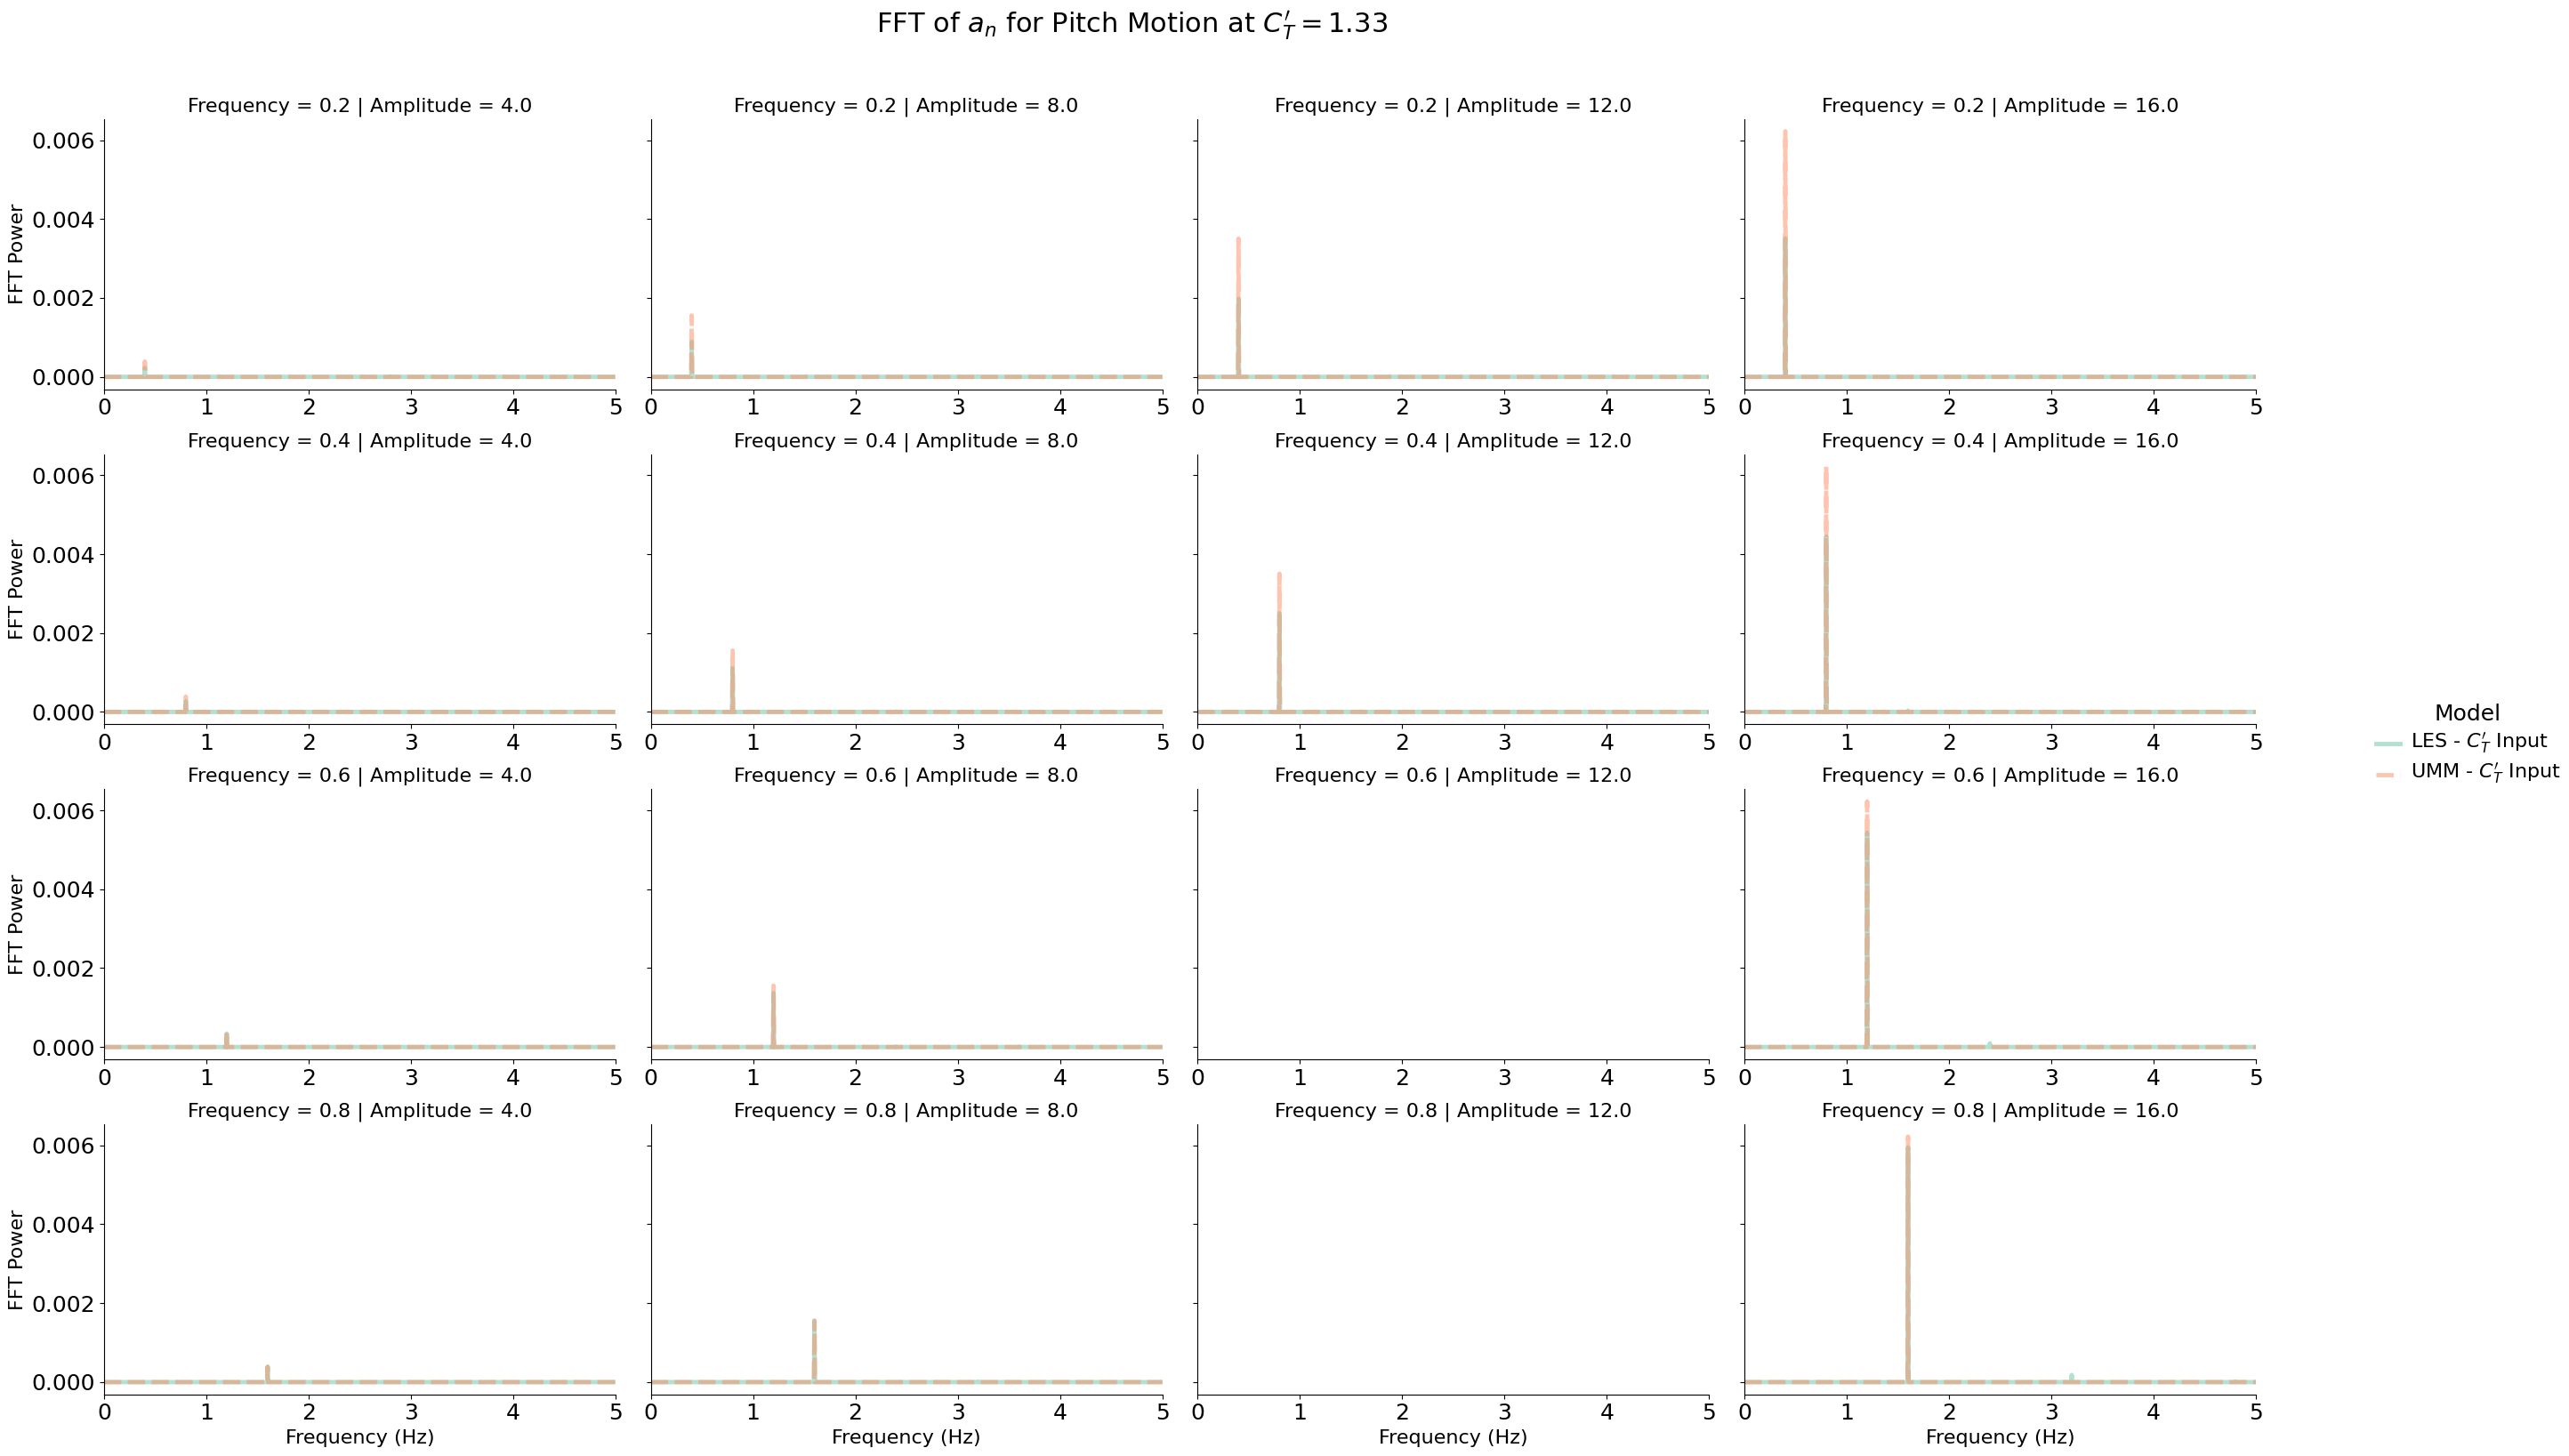

In [267]:
g = sns.relplot(
    data=fft_pitch_df[fft_pitch_df["Local Thrust Coefficient"] == 1.33],
    x="fft_freq",
    y="fft_power",
    hue="Model",
    style = "Model",
    col="Amplitude",
    row="Frequency",
    kind="line",
    height=4,
    aspect=1.5,
    palette="Set2",
    facet_kws={"sharey": "row", "sharex": False},
    errorbar= None,
    linewidth=3.5,
    alpha = 0.5
)

g.set_titles(row_template="Frequency = {row_name}", col_template="Amplitude = {col_name}", size = 16)
g.set_axis_labels("Frequency (Hz)", "FFT Power", fontsize = 16)
g._legend.set_title("Model", prop={'size': 18}); [t.set_fontsize(16) for t in g._legend.get_texts()]
g._legend.set_bbox_to_anchor((1.04, 0.5))  # (x, y) position relative to figure
g._legend.set_loc("center left")
[ax.tick_params(labelsize=18) for ax in g.axes.flat]
g.figure.suptitle("FFT of $a_n$ for Pitch Motion at $C_T' = 1.33$", fontsize=22, y = 1.02)
plt.tight_layout()
g.set(xlim=(0, 5))